{'Rotation': 0.0, 'Particles': 1000}


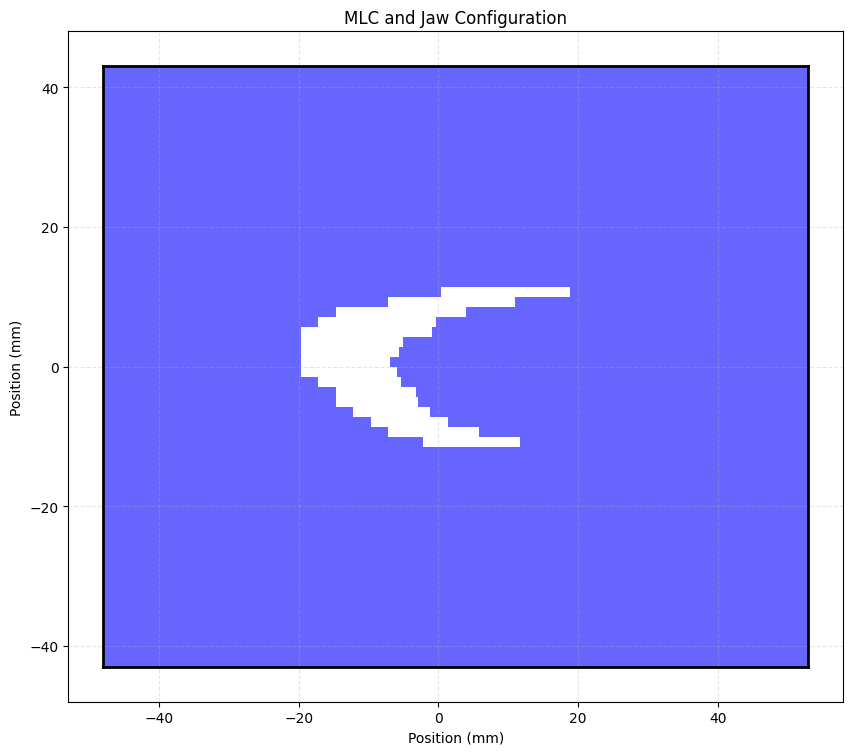

In [43]:
import numpy as np
import matplotlib.pyplot as plt

file = "1. prostate_imrt_beam0_cp0.dat"

def parse_mlc_data():
    with open(file) as fp:
      data = fp.read()
    lines = data.strip().split('\n')
    
    # read data from comments
    comments = [line for line in lines if line.startswith('#')]
    comment_params = {}
    for comment in comments:
        key = comment.removeprefix("# ").rstrip("0123456789. :")
        value = comment.removeprefix('# ').split(" ", 1)[1]
        if '.' in value:
            try:
                value = float(value)
            except ValueError:
                continue
        else:
            try:
                value = int(value)
            except ValueError:
                continue
        comment_params[key] = value
    
    # remove comments, no longer needed
    lines = [line for line in lines if not line.startswith("#")]
    
    # Parse jaws data
    jaws = map(float, lines[0].split(','))
    
    # Parse MLC positions
    mlc_positions = []
    for line in lines[1:]:
        if ',' in line:
            left, right = map(float, line.split(','))
            mlc_positions.append((left, right))
    
    return jaws, np.array(mlc_positions), comment_params

def plot_mlc_configuration():
    # Parse data
    (X1, X2, Y1, Y2), mlc_positions, comment_params = parse_mlc_data()
    print(comment_params)
    
    # Create figure
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    # Calculate leaf heights
    n_leaves = len(mlc_positions)
    leaf_heights = np.linspace(Y1, Y2, n_leaves + 1)
    leaf_height = (Y2 - Y1) / n_leaves # width of rectangles
    
    # Plot each MLC leaf pair
    # data is arranged bottom-up
    for i, (left, right) in enumerate(mlc_positions):
        y_pos = leaf_heights[i]

        # plot rectangles

        # (X1, y_pos + leaf_height)-----(left, ypos + leaf_height)
        # |                                       |
        # (X1, y_pos)-------------------(left, y_pos)
        plt.fill([X1, left, left, X1],
                [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
                'blue', alpha=0.6)
        
        # (right, y_pos + leaf_height)-----(X2, ypos + leaf_height)
        # |                                       |
        # (right, y_pos)-------------------(X2, y_pos)
        plt.fill([right, X2, X2, right],
                [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
                'blue', alpha=0.6)
    
    # Plot jaw boundaries
    plt.plot([X1, X1], [Y1, Y2], 'k-', linewidth=2)  # Left jaw
    plt.plot([X2, X2], [Y1, Y2], 'k-', linewidth=2)  # Right jaw
    plt.plot([X1, X2], [Y1, Y1], 'k-', linewidth=2)  # Bottom jaw
    plt.plot([X1, X2], [Y2, Y2], 'k-', linewidth=2)  # Top jaw
    
    # Set plot properties
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')
    plt.title('MLC and Jaw Configuration')
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal')
    plt.xlim(X1 - 5, X2 + 5)
    plt.ylim(Y1 - 5, Y2 + 5)
    
    return plt.gcf()

# Create and display the plot
fig = plot_mlc_configuration()
plt.show()

In [ ]:
import pandas as pd
import polars as pl
import pyarrow as pa
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, min, max):
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
  
  # phantom_counts_norm = colors.LogNorm(vmin=min, vmax=max)
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)

if __name__ == "__main__":
  dtypes_polars = {
  'X [mm]': pl.Float64,
  'Y [mm]': pl.Float64,
  'Z [mm]': pl.Float64,
  'Material': pl.Utf8,
  'Dose [Gy]': pl.Float64,
  'FieldScalingFactor': pl.Float64,
  # Add more columns and their dtypes as needed
  }
  filename = "img001.csv"
  df = pl.read_csv(filename, schema_overrides=dtypes_polars)

  # Convert Polars DataFrame to Pandas DataFrame
  pandas_df = df.to_pandas()
  cell_df = pandas_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  voxel_side_len = 0.985
  observable = "FieldScalingFactor"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')
  print (cell_df.size)
  
  # cell_df = cell_df[cell_df['Z [mm]'] > -4]
  # cell_df = cell_df[cell_df['Z [mm]'] < 2]
  dose_max = cell_df[observable].max()
  dose_min = cell_df[cell_df[observable]>0][observable].min()
  
  # cell_df.to_csv('cell_ct_cp1_job23.csv', index=False)
  
  print (cell_df.size)
  
  for _, row in cell_df.iterrows():
      if row[observable] == 0:
          continue
      x_center = row['X [mm]']
      y_center = row['Y [mm]']
      z_center = row['Z [mm]']

      dose = row[observable]
      add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, dose_min, dose_max)

  # Ustawienie limitów osi
  x_min, x_max = cell_df['X [mm]'].min() - voxel_side_len, cell_df['X [mm]'].max() + voxel_side_len
  y_min, y_max = cell_df['Y [mm]'].min() - voxel_side_len, cell_df['Y [mm]'].max() + voxel_side_len
  z_min, z_max = cell_df['Z [mm]'].min() - voxel_side_len, cell_df['Z [mm]'].max() + voxel_side_len
  
  print(x_min, x_max, y_min, y_max, z_min, z_max)

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  # scalar_mappable = cm.ScalarMappable(norm=colors.LogNorm(vmin=dose_min/100, vmax=dose_max), cmap=phantom_counts_cmap)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()

